Animation showing line-of-sight from Earth to other planets, illustrating the cause of retrograde motion.

I wrote this script in Carnets app on my iPad ( https://apps.apple.com/us/app/carnets/id1450994949 ). There's a quirk in the compiler (or interpreter) that causes the code to fail with an error message `AttributeError: 'NoneType' object has no attribute 'remove_callback'`. I just ignore it and it runs the second time.

This script uses Skyfield api ( https://rhodesmill.org/skyfield/planets.html ).

Although I probably can't help you debug your program I would love to hear if you use this animation (or derivative) in your lessons.

Good luck,

Stephen Shadle 🌌

swshadle@gmail.com

# Version Control

Skyfield Retrograde Multiple HUD 5a: displaying frame # in text to test whether i can display events in real time rather than all at once before the animation starts. putting frame # in place of time of day for events

Skyfield Retrograde Multiple HUD 5: cleaning dates (array t) as well as delta longitude (array mars_eclondel) by combining them into a two-dimentional array (data2d), where the 0th column is delta ecliptic longitude and 1st column is dates

Skyfield Retrograde Multiple HUD 4: display start and end retrograde for mars using indexes found in mars_motion_chg

Skyfield Retrograde Multiple HUD 1-3: move plot to the left using plt.subplots_adjust(left=-0.25, right=1), added text labels for mars starting and ending retrograde, and cleaned data using reject_outliers

Skyfield Retrograde Multiple HUD: Original ready-for-publication version showing retrograde of inner planets in red

<IPython.core.display.Javascript object>


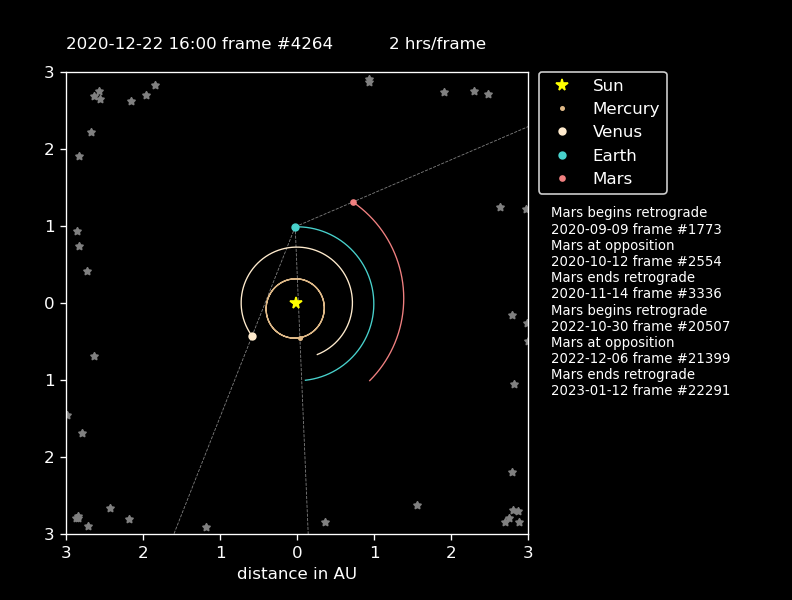

FFMpegWriter is available
2 seconds elapsed


In [4]:
# use "%pip install" to load skyfield api once then comment the line out:
###### %pip install skyfield
from skyfield.api import load
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter, PillowWriter
import matplotlib.animation as animations
from datetime import datetime
%matplotlib notebook

start_time = datetime.now()

# constructor class for making planets
class planets:
    def __init__(self, name, marker=None, color=None, markersize=None, trailmax=None):
        self.name       = name
        self.marker     = marker if marker is not None else 'o'
        self.color      = color if color is not None else 'k'
        self.markersize = markersize if markersize is not None else 1

# create a list of solar system objects
plist = []

# append instances to list
plist.append(planets(name='Sun',     color='yellow',          markersize=7, marker='*'))
plist.append(planets(name='Mercury', color='burlywood',       markersize=2))
plist.append(planets(name='Venus',   color='blanchedalmond',  markersize=4))
plist.append(planets(name='Earth',   color='mediumturquoise', markersize=4))
plist.append(planets(name='Mars',    color='lightcoral',      markersize=3))
# plist.append(planets(name='Jupiter', color='burlywood',       markersize=6))
# plist.append(planets(name='Saturn',  color='seashell',        markersize=5))
# plist.append(planets(name='Uranus',  color='paleturquoise',   markersize=5))
# plist.append(planets(name='Neptune', color='royalblue',       markersize=5))
# plist.append(planets(name='Pluto',   color='lightsalmon',     markersize=2))

# load skyfield ephemeris table from local directory (see https://rhodesmill.org/skyfield/planets.html)
eph = load('de421.bsp')
sun     = eph[plist[0].name]
mercury = eph[plist[1].name]
venus   = eph[plist[2].name]
earth   = eph[plist[3].name]
mars    = eph[plist[4].name]
# jupiter = eph['Jupiter barycenter']
# saturn  = eph['Saturn barycenter']
# urаnus  = eph['Uranus barycenter']
# neptune = eph['Neptune barycenter']
# pluto   = eph['Pluto barycenter']

ts = load.timescale()

hours = (3*365+66)*24 # how long the animation should run (number of hours of data from ephemeris table)

interval = 2          # number of hours to skip forward for each frame of the animation
dpi = 120             # dots per inch for the image
hw = 3.0              # height and width of the figure, in AU

# ephemeris table de421.bsp is only valid through 2053 Oct 9 (Julian date 2471184.5)
numremoved = 0        # zero data points removed due to valid date range (so far!)

start_y = start_time.year
start_m = start_time.month
start_d = start_time.day

t = ts.utc(start_y,start_m,start_d,range(hours))
while len(t)>1 and t[-1].tt>2471184.5:
    t=t[:-1]
    numremoved += 1

if numremoved:
    print(f'removed {numremoved} frames')
    hours -= numremoved
    t  = ts.utc(start_y,start_m,start_d,range(hours))

# give an assertion error if there is no remaining valid data
assert t[-1].tt<2471184.5, 'Dates are out of range'
assert hours>0, f'too few hours selected: {hours}'

sun_p     = eph[plist[0].name].at(t).ecliptic_position().au
mercury_p = eph[plist[1].name].at(t).ecliptic_position().au
venus_p   = eph[plist[2].name].at(t).ecliptic_position().au
earth_p   = eph[plist[3].name].at(t).ecliptic_position().au
# moon_p    = moon.at(t).ecliptic_position().au
mars_p    = eph[plist[4].name].at(t).ecliptic_position().au
# jupiter_p = jupiter.at(t).ecliptic_position().au
# saturn_p  = saturn.at(t).ecliptic_position().au
# uranus_p  = urаnus.at(t).ecliptic_position().au
# neptune_p = neptune.at(t).ecliptic_position().au
# pluto_p   = pluto.at(t).ecliptic_position().au

ps = [sun_p,
      mercury_p,
      venus_p,
      earth_p,
#       moon_p,
      mars_p,
#       jupiter_p,
#       saturn_p,
#       uranus_p,
#       neptune_p,
#       pluto_p,
     ]

maxsize = [-hw, hw]

# with plt.xkcd(): # uncomment (and indent the rest of the script) if you want the figure to be in xkcd style (see https://matplotlib.org/xkcd/examples/showcase/xkcd.html)
fig = plt.figure(figsize=(6.6, 5), dpi=dpi)

ax  = fig.add_subplot(1, 1, 1,
#                        projection ='3d',
                      )

plt.subplots_adjust(left=-0.25, right=1) # moves the plot to reduce the left margin

# some background stars (from https://github.com/zingale/astro_animations/blob/master/solar_system_motion/retrograde/retrograde.py)
import random
N = 40
xpos = []
ypos = []
starbox = [2.6, 3.0]
for s in range(N):
    # right
    xpos.append(random.uniform( starbox[0], starbox[1]))
    ypos.append(random.uniform(-starbox[1], starbox[1]))

    # top
    xpos.append(random.uniform(-starbox[1], starbox[1]))
    ypos.append(random.uniform( starbox[0], starbox[1]))

    # left
    xpos.append(random.uniform(-starbox[0],-starbox[1]))
    ypos.append(random.uniform(-starbox[1], starbox[1]))

    # bottom
    xpos.append(random.uniform(-starbox[1], starbox[1]))
    ypos.append(random.uniform(-starbox[0],-starbox[1]))

# draw some random background stars
for s in range(N):
    plt.scatter([xpos[s]], [ypos[s]], s=20, marker=(5,1), color="grey")
plt.show()

dots   = []
trails = []

for i,p in enumerate(ps):
    x, y, z = p # z is ignored in 2D plots

    newdot, = plt.plot([x[0]],
                       [y[0]],
#                        [z[0]],
                       marker=plist[i].marker,
                       ms=plist[i].markersize,
                       label=plist[i].name,
                       color=plist[i].color,
                      linestyle = 'None',
                      )
    dots.append(newdot)
    
    newtrail, = plt.plot(x[:1],
                         y[:1],
#                          z[:1],
                         color=plist[i].color,
                         linewidth=0.01,
#                          marker='.',
#                          ms=0.01,
#                          linestyle = 'None',
                        )

    trails.append(newtrail)

mercury_x, mercury_y, mercury_z = ps[1]
venus_x, venus_y, venus_z       = ps[2]
earth_x, earth_y, earth_z       = ps[3]
mars_x, mars_y, mars_z          = ps[4]

# get slopes for line-of-sight lines from earth through other planets
mars_slope     = (earth_y[0] -    mars_y[0])/(earth_x[0] -    mars_x[0])
venus_slope    = (earth_y[0] -   venus_y[0])/(earth_x[0] -   venus_x[0])
mercury_slope  = (earth_y[0] - mercury_y[0])/(earth_x[0] - mercury_x[0])

# endpoint of line-of-sight line should be to the right of the figure if the planet is to the right of earth & vice versa
if earth_x[0]>mars_x[0]:
    mars_xpt = -3.5
else:
    mars_xpt = 3.5

mars_ypt = earth_y[0] + mars_slope*(mars_xpt - earth_x[0])

if earth_x[0]>venus_x[0]:
    venus_xpt = -3.5
else:
    venus_xpt = 3.5

venus_ypt = earth_y[0] + venus_slope*(venus_xpt - earth_x[0])

if earth_x[0]>mercury_x[0]:
    mercury_xpt = -3.5
else:
    mercury_xpt = 3.5

mercury_ypt = earth_y[0] + mercury_slope*(mercury_xpt - earth_x[0])

eclat, mars_eclon, ecd = earth.at(t).observe(mars).ecliptic_latlon()
mars_eclondel = mars_eclon.radians[1:] - mars_eclon.radians[:-1]

mars_data2d = np.stack((mars_eclondel, t[:-1]), axis=1) # make a 2d data structure where column 0 is delta ecliptic longitude and column 1 is dates

def reject_outliers(data, m=2.):
    d = np.abs(data[:,0] - np.median(data[:,0]))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

filtered_mars_data2d = reject_outliers(mars_data2d,200.)

# def reject_outliers(data, m=2.):
#     d = np.abs(data - np.median(data))
#     mdev = np.median(d)
#     s = d/mdev if mdev else 0.
#     return data[s<m]

# filtered_mars_eclondel = reject_outliers(mars_eclondel,200.)


# identify where mars is in prograde (which we will mark with a grey line) and retrograde (orange-red line)
# mars_prograde = filtered_mars_eclondel >= 0.0
mars_prograde = filtered_mars_data2d[:,0] >= 0.0

mars_motion_chg = np.where(mars_prograde[:-1] != mars_prograde[1:])[0]+1

text_x = 1.05
text_y = 0.65
text_y_delta = 0.07

opposition = 0
fontsize=8
for i in mars_motion_chg:
    if not mars_prograde[i]:
#         ax.text(text_x, text_y, 'Mars begins retrograde\n{:%Y-%m-%d %H:%M}'.format(t[i].utc_datetime()), transform=ax.transAxes)
        opposition = i
        ax.text(text_x, text_y, 'Mars begins retrograde\n{:%Y-%m-%d} frame #{}'.format(filtered_mars_data2d[i,1].utc_datetime(), i), transform=ax.transAxes, fontsize=fontsize)
    else:
#         ax.text(text_x, text_y, 'Mars ends retrograde\n{:%Y-%m-%d %H:%M}'.format(t[i].utc_datetime()), transform=ax.transAxes)
        if opposition != 0:
            opposition = (opposition + i) // 2 # integer floor division
            ax.text(text_x, text_y, 'Mars at opposition\n{:%Y-%m-%d} frame #{}'.format(filtered_mars_data2d[opposition,1].utc_datetime(), opposition), transform=ax.transAxes, fontsize=fontsize)
            text_y -= text_y_delta
        ax.text(text_x, text_y, 'Mars ends retrograde\n{:%Y-%m-%d} frame #{}'.format(filtered_mars_data2d[i,1].utc_datetime(), i), transform=ax.transAxes, fontsize=fontsize)
    text_y -= text_y_delta

    
# ax.text(text_x, text_y, 'Mars begins retrograde', transform=ax.transAxes) # label for start of retrograde
# ax.text(1.05, 0.60, '', transform=ax.transAxes) # date  for start of retrograde
# ax.text(1.05, 0.55, 'Mars ends retrograde', transform=ax.transAxes) # label for end   of retrograde
# ax.text(1.05, 0.50, '', transform=ax.transAxes) # date  for end   of retrograde
        
# store an array of colors (grey or orangered)
mars_linecolor = ['grey' if mars_prograde[i] else 'orangered' for i in range(len(mars_prograde))]

# create the line that shows line-of-sight through mars at the first (0th) data point. we'll do the rest in the animate function
mars_line,  = plt.plot([earth_x[0], mars_xpt], [earth_y[0], mars_ypt], "--",
                   linewidth=0.5) # line connecting earth and mars
mars_line.set_color(mars_linecolor[0])

eclat, venus_eclon, ecd = earth.at(t).observe(venus).ecliptic_latlon()
venus_eclondel = venus_eclon.radians[1:] - venus_eclon.radians[:-1]
venus_prograde = venus_eclondel >= 0.
venus_linecolor = ['grey' if venus_prograde[i] else 'orangered' for i in range(len(venus_prograde))]
venus_line,  = plt.plot([earth_x[0], venus_xpt], [earth_y[0], venus_ypt], "--",
                   linewidth=0.5) # line connecting earth and venus
venus_line.set_color(venus_linecolor[0])

eclat, mercury_eclon, ecd = earth.at(t).observe(mercury).ecliptic_latlon()
mercury_eclondel = mercury_eclon.radians[1:] - mercury_eclon.radians[:-1]
mercury_prograde = mercury_eclondel >= 0.
mercury_linecolor = ['grey' if mercury_prograde[i] else 'orangered' for i in range(len(mercury_prograde))]
mercury_line,  = plt.plot([earth_x[0], mercury_xpt], [earth_y[0], mercury_ypt], "--",
                   linewidth=0.5) # line connecting earth and mercury
mercury_line.set_color(mercury_linecolor[0])

ax.set_xlim(maxsize)
ax.set_ylim(maxsize)
# ax.set_zlim(maxsize) # not used in a 2D plot

ax.set_ylabel(None, 
              labelpad = 14,
             ) # elevation
ax.set_xlabel('distance in AU',
#               labelpad = 14,
             )
# ax.set_zlabel(None)   # not used in a 2D plot

# set up animation of axis ticks and labels
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax.zaxis.set_major_locator(MaxNLocator(integer=True))

ticks =  ax.get_yticks()
ticks = ticks[1:] # compensates for an error in some versions of the 3d view system. might not be needed (you might have better results if you comment or uncomment this line)

# set labels to integers with absolute values (representing distance from sun in AU)
ax.set_xticklabels([int(abs(tick)) for tick in ticks])
ax.set_yticklabels([int(abs(tick)) for tick in ticks])
# ax.set_zticklabels([int(abs(tick)) for tick in ticks])

handles, labels = ax.get_legend_handles_labels()
plt.style.use(['dark_background'])
plt.rcParams['figure.facecolor'] = 'black'
plt.legend(bbox_to_anchor=(1.3, 1.0), # sets the legend outside the figure
               handles=handles,       # our updated list of handles
               loc='upper right',
               ncol=1,
               fontsize='medium',
               borderaxespad=0.0,
               shadow=True,
              )

ax.set_aspect('equal') # makes circles look like circles

if interval == 24:
    timeperframe = '1 day'
elif interval > 24:
    if interval%24==0:
        timeperframe = f'{interval//24} days'
    else:
        timeperframe = '{:^.1f} days'.format(interval/24)
elif interval == 1:
    timeperframe = '1 hr'
else:
    timeperframe = f'{interval} hrs'

# placement 0, 0 would be bottom-left. 1, 1 would be top-right.
text1 = ax.text(0.0, 1.05, '', transform=ax.transAxes) # date/time for each frame
text2 = ax.text(0.7, 1.05, f'{timeperframe}/frame', transform=ax.transAxes) # hours or days per frame of animation

# mars_text_retro_beg  = ax.text(1.05, 0.65, 'Mars begins retrograde', transform=ax.transAxes) # label for start of retrograde
# mars_date_retro_beg  = ax.text(1.05, 0.60, '', transform=ax.transAxes) # date  for start of retrograde
# mars_text_retro_end  = ax.text(1.05, 0.55, 'Mars ends retrograde', transform=ax.transAxes) # label for end   of retrograde
# mars_date_retro_end  = ax.text(1.05, 0.50, '', transform=ax.transAxes) # date  for end   of retrograde

# init function doesn't do anything currently. it's there if any setup is needed before starting the animation
def init():
    return dots, trails

def animate(hour):
    pctleft = (hours-hour-hours%interval)/hours
    pctzoom = 0.025+1.0*(1-np.sin((np.pi/2)*(pctleft)))
    text1.set_text('{:%Y-%m-%d %H:%M} frame #{}'.format(t[hour].utc_datetime(), hour))
    ticks =  ax.get_yticks()
    
#   use decimal axis labels when zoomed in
    if pctzoom<0.0245:                  # :^.1f
        ax.set_xticklabels([f'{abs(tick):.1f}' for tick in ticks])
        ax.set_yticklabels([f'{abs(tick):.1f}' for tick in ticks])
#         ax.set_zticklabels([f'{abs(tick):.1f}' for tick in ticks])
    else:
        ax.set_xticklabels([int(abs(tick)) for tick in ticks])
        ax.set_yticklabels([int(abs(tick)) for tick in ticks])
#         ax.set_zticklabels([int(abs(tick)) for tick in ticks])

# update the postion and trails for each planet
    for i,p in enumerate(ps):
        x, y, z = p # z is ignored in 2D plots
        dots[i].remove()
        dots[i], = plt.plot([x[hour]], [y[hour]],
#                             [z[hour]],
                            marker=plist[i].marker,
                            ms=plist[i].markersize,
                            color=plist[i].color,
                            linestyle = 'None',
                        )

        trails[i].remove()
        trails[i], = plt.plot(x[:hour], y[:hour],
#                               z[:hour],
                              color=plist[i].color,
                              linewidth= 0.8,
                              alpha = 1,
                        )

    # draw a line connecting earth and another planet and extending a bit further out
    mars_slope    = (earth_y[hour] -    mars_y[hour])/(earth_x[hour] -    mars_x[hour])
    venus_slope   = (earth_y[hour] -   venus_y[hour])/(earth_x[hour] -   venus_x[hour])
    mercury_slope = (earth_y[hour] - mercury_y[hour])/(earth_x[hour] - mercury_x[hour])

    if earth_x[hour]>mars_x[hour]:
        mars_xpt = -3.5
    else:
        mars_xpt = 3.5

    mars_ypt = earth_y[hour] + mars_slope*(mars_xpt - earth_x[hour])

    if earth_x[hour]>venus_x[hour]:
        venus_xpt = -3.5
    else:
        venus_xpt = 3.5

    venus_ypt = earth_y[hour] + venus_slope*(venus_xpt - earth_x[hour])

    if earth_x[hour]>mercury_x[hour]:
        mercury_xpt = -3.5
    else:
        mercury_xpt = 3.5

    mercury_ypt = earth_y[hour] + mercury_slope*(mercury_xpt - earth_x[hour])

    mars_line.set_data((earth_x[hour], mars_xpt), (earth_y[hour], mars_ypt))
    mars_line.set_color(color=mars_linecolor[hour])
    
#     mars_date_retro_beg.set_text('{:%Y-%m-%d %H:%M}'.format(t[hour].utc_datetime()))
#     mars_date_retro_end.set_text('{:%Y-%m-%d %H:%M}'.format(t[hour].utc_datetime()))

    venus_line.set_data((earth_x[hour], venus_xpt), (earth_y[hour], venus_ypt))
    venus_line.set_color(color=venus_linecolor[hour])

    mercury_line.set_data((earth_x[hour], mercury_xpt), (earth_y[hour], mercury_ypt))
    mercury_line.set_color(color=mercury_linecolor[hour])

#     print(f'frame {hours-hour-hours%interval}/{hours} {pctleft:.0%} left')
    return dots, trails

# lambda function prints the progress to the console while rendering the animation.
progress_callback = lambda i, n: print(f'Saving frame {i+1} of {n}')
# plt.show() # normally you need to tell matplotlib and pyplot to show the plot. this isn't needed when using FuncAnimation
animation = FuncAnimation(fig, animate, 
                          frames=range(0,hours,interval), # run the animation for all days represented
                          interval=10, blit=False, repeat=False, 
                          repeat_delay=5,
                          init_func=init)

filename = f"retrograde multiple.{dpi} dpi.{hours} pts.{interval} interval"

# please update the 'artist' metadata for your animation file by putting your name as the artist:
artist = 'Stephen Shadle'

if FFMpegWriter.isAvailable():
    print('FFMpegWriter is available')
    writer = FFMpegWriter(fps=15, metadata=dict(artist=artist), bitrate=1800)
# comment the following line to run animation without saving the file
#     animation.save(filename=f'{filename}.mp4', writer=writer, progress_callback=progress_callback)
else:
    print('FFMpegWriter is not available')
    if PillowWriter.isAvailable():
        print('PillowWriter is available')
        Writer = animations.writers['pillow']
        writer = Writer(fps=60, metadata=dict(artist=artist), bitrate=1800,)
# comment the following line to run animation without saving the file
#         animation.save(filename=f'{filename}.gif', writer=writer, dpi=dpi)
    else:
        print('PillowWriter is not available')

# elapsed time function
# PLACE THE FOLLOWING AT THE TOP
# from datetime import datetime
# from time import sleep
# start_time = datetime.now()

time_elapsed = datetime.now() - start_time

da, remainder  = divmod(time_elapsed.total_seconds(), 24*3600)
hrs, remainder = divmod(remainder, 3600)
mins, secs = divmod(remainder, 60)

if da:
    print(f'{int(da)} days {int(hrs)} hours {int(mins)} minutes {int(secs)} seconds elapsed')
elif hrs:
    print(f'{int(hrs)} hours {int(mins)} minutes {int(secs)} seconds elapsed')
elif mins:
    print(f'{int(mins)} minutes {int(secs)} seconds elapsed')
else:
    print(f'{int(secs)} seconds elapsed')

In [27]:
type(mars_prograde[0])

numpy.bool_

In [28]:
mars_motion_chg

array([ 1797,  1867, 19038, 19110])

In [29]:
mars_prograde

array([ True,  True,  True, ...,  True,  True,  True])

In [56]:
len(mars_eclondel)

27863

In [57]:
len(t)

27864

In [60]:
data2d = np.stack((mars_eclondel, t[:-1]), axis=1)

In [86]:
data2d[1000,1]

<Time tt=2459069.1674674074>

In [77]:
data2d = np.stack((mars_eclondel, t[:-1]), axis=1)

def reject_outliers(data, m=2.):
    d = np.abs(data[:,0] - np.median(data[:,0]))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

filtered_mars_eclondel = reject_outliers(data2d,200.)

In [78]:
len(mars_eclondel)

27863

In [79]:
len(filtered_mars_eclondel)

27861

In [1]:
list(filtered_mars_eclondel[:,1])

NameError: name 'filtered_mars_eclondel' is not defined

In [36]:
filtered_mars_eclondel

array([0.00044319, 0.0004431 , 0.00044302, ..., 0.00046798, 0.000468  ,
       0.00046803])

In [37]:
for i in mars_motion_chg:
    if not mars_prograde[i]:
        print('Mars begins retrograde\n{:%Y-%m-%d %H:%M}'.format(t[i].utc_datetime()))
    else:
        print('Mars ends retrograde\n{:%Y-%m-%d %H:%M}'.format(t[i].utc_datetime()))

Mars begins retrograde
2020-09-09 21:00
Mars ends retrograde
2020-09-12 19:00
Mars begins retrograde
2022-08-29 06:00
Mars ends retrograde
2022-09-01 06:00
